<a href="https://colab.research.google.com/github/Mitmischer/sepsis-prediction/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [97]:
%pip install zstandard
import zstandard
drive.mount('/content/drive')
%mkdir -p "/tmp/sepsis"
%cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
%cd "/tmp/sepsis"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/tmp/sepsis


In [98]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)

my_tar = tarfile.open('training.tar')
my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
my_tar.close()
%cd "training/training_setA"

/tmp/sepsis/training/training_setA


In [124]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

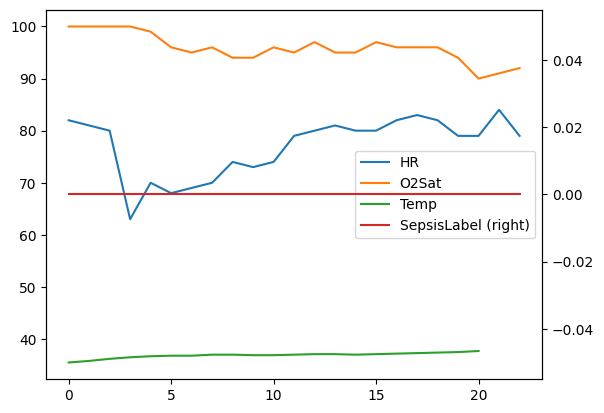

In [125]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

In [101]:
first_patient_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [122]:
# load the first 10 data sets
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
big_df = pd.concat(big_df)

<Axes: >

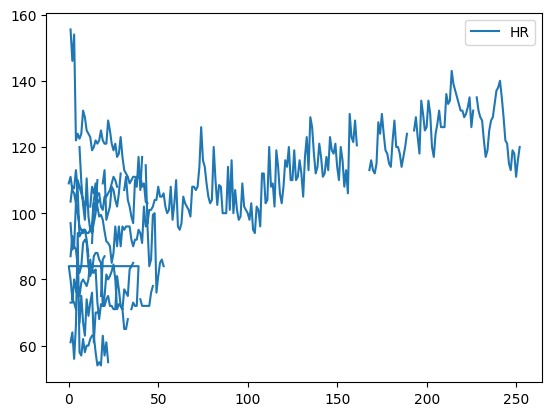

In [123]:
big_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

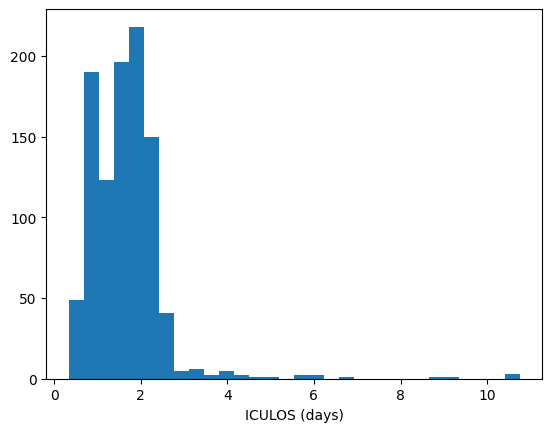

In [166]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')